#Project - HOT DOG  NOT HOT DOG Classifier
## This project aims to make a classifier that given an image of any food , capable of accurately predicting whether the image contains hot dog or not.
## This project also makes use of transfer learning and uses resnet152 pretrained model.

Let's first download and set up kaggle so that we can easily get the dataset.

In [0]:
!pip install kaggle

In [25]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


Go to my account on kaggle and click on get my new token , and download .json file and open and copy username and key in the following piece of code.

In [0]:
import json
token = {"username":"souravs17031999","key":"0a0aff6ecce9a6bd0cbdeb4272df70cd"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

Set the path for downloading the files

In [28]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json


Now you can go to datasets page and then click on get API command and copy it and paste it here using '!'

In [31]:
!kaggle datasets download -d dansbecker/hot-dog-not-hot-dog

hot-dog-not-hot-dog.zip: Skipping, found more recently modified local copy (use --force to force download)


In [32]:
!unzip ./{/content}/datasets/dansbecker/hot-dog-not-hot-dog/hot-dog-not-hot-dog.zip

Archive:  ./{/content}/datasets/dansbecker/hot-dog-not-hot-dog/hot-dog-not-hot-dog.zip
replace test/hot_dog/133012.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Let's get started by first importing all the necessary packages

In [0]:
import torch
from torch import optim, nn
import torchvision
from torchvision import datasets, models, transforms
import numpy as np

In [47]:
!wget -c https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py

--2019-07-12 14:17:23--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



Set the directory path

In [0]:
train_dir = 'train'
valid_dir = 'test'

Apply the transforms accordingly with pre calculated means and std for the images of this dataset.

In [0]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),transforms.RandomResizedCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

Loading the dataset with data augmentation !

In [0]:
train_data = datasets.ImageFolder(train_dir , transform=train_transforms)
test_data = datasets.ImageFolder(valid_dir, transform=test_transforms)

In [0]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

The below code shows the structure of dataset

In [59]:
print(f"training examples contain : {len(train_data)}")
print(f"testing examples contain : {len(test_data)}")


training examples contain : 498
testing examples contain : 500


In [0]:
images, labels = next(iter(testloader))

We have set the batch size as 64 , therefore we have here tensor of shown dimensions where 64 is batch size , 3 is color channels and 224 x 224 are height and width which we have set during data augmentation , so that each image is of same size.

In [57]:
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [0]:
class_names = train_data.classes

Function for denormalizing the pixel values 

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

Function for plotting normalized images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


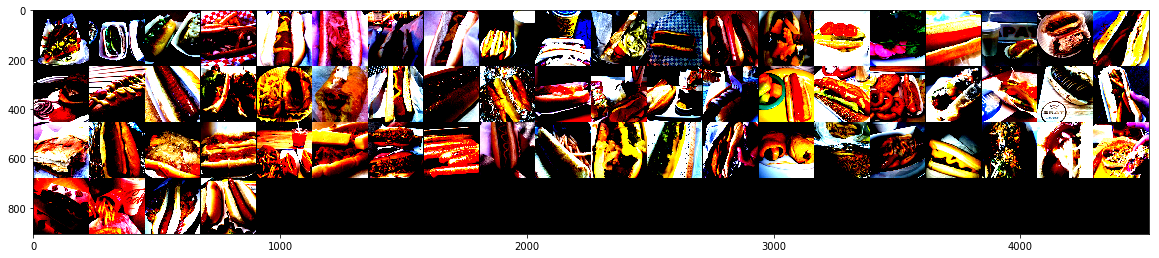

In [53]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
grid = torchvision.utils.make_grid(images, nrow = 20, padding = 2)
plt.figure(figsize = (20, 20))  
plt.imshow(np.transpose(grid, (1, 2, 0)))   
print('labels:', labels)


Printing unnormalized images

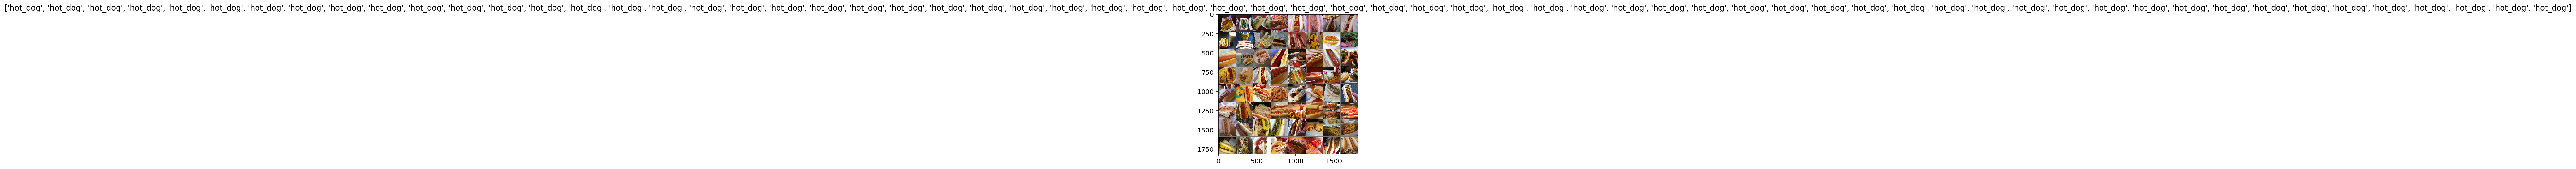

In [85]:
images, labels = next(iter(testloader))
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])


In [54]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Define the model resnet152 and the fully connected layers here with optimizer and loss functions

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

    
model.fc = nn.Sequential(nn.Linear(2048, 512),nn.ReLU(),nn.Linear(512,2),nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()


optimizer = torch.optim.Adam(model.fc.parameters() , lr = 0.01)
model.to(device);


Let's start the normal training and testing loop.

In [89]:
epochs = 15
train_losses, test_losses = [], []
model.train()

for e in range(epochs):
  running_loss = 0
  batch = 0
  for images, labels in trainloader:
    optimizer.zero_grad()
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    batch += 1
    print(f" epoch {e} batch {batch} completed")
  else:
    test_loss = 0
    accuracy = 0
    with torch.no_grad():
      model.eval()
      for images, labels in testloader:
        images = images.to(device)  
        labels = labels.to(device)
        log_ps = model(images)
        test_loss += criterion(log_ps,labels)
        ps = torch.exp(log_ps)
        top_p , top_class = ps.topk(1,dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))   
    print("Epoch: {}/{}.. ".format(e+1, epochs),"Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),"Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),"Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

 epoch 0 batch 1 completed
 epoch 0 batch 2 completed
 epoch 0 batch 3 completed
 epoch 0 batch 4 completed
 epoch 0 batch 5 completed
 epoch 0 batch 6 completed
 epoch 0 batch 7 completed
 epoch 0 batch 8 completed
Epoch: 1/15..  Training Loss: 9.064..  Test Loss: 0.632..  Test Accuracy: 0.613
 epoch 1 batch 1 completed
 epoch 1 batch 2 completed
 epoch 1 batch 3 completed
 epoch 1 batch 4 completed
 epoch 1 batch 5 completed
 epoch 1 batch 6 completed
 epoch 1 batch 7 completed
 epoch 1 batch 8 completed
Epoch: 2/15..  Training Loss: 1.178..  Test Loss: 0.688..  Test Accuracy: 0.513
 epoch 2 batch 1 completed
 epoch 2 batch 2 completed
 epoch 2 batch 3 completed
 epoch 2 batch 4 completed
 epoch 2 batch 5 completed
 epoch 2 batch 6 completed
 epoch 2 batch 7 completed
 epoch 2 batch 8 completed
Epoch: 3/15..  Training Loss: 0.542..  Test Loss: 0.364..  Test Accuracy: 0.884
 epoch 3 batch 1 completed
 epoch 3 batch 2 completed
 epoch 3 batch 3 completed
 epoch 3 batch 4 completed
 epo

Let's see model complexity graph so that we can analyse cases like overfitting.

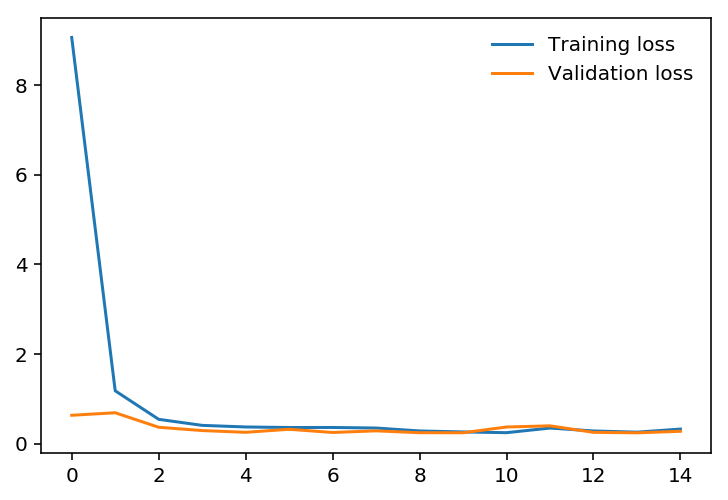

In [90]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

We have completed this project with almost 90% accuracy.